##Importando Bibliotecas e Banco de dados

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Definir as ações
ticker2 = "CSNA3.SA"
dolar = "USDBRL=X"

# Definir as datas inicial e final
data_inicial = "2017-01-01"
data_final = "2022-12-31"

# Baixar os dados históricos
dados_csna = yf.download(ticker2, data_inicial, data_final)
cotacao_dolar = yf.download(dolar, data_inicial, data_final)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Visualizar os dados
dados_csna

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,10.70,10.94,10.61,10.86,7.050705,1127100
2017-01-03,11.07,11.42,10.91,11.42,7.414278,6602900
2017-01-04,11.35,11.55,11.14,11.31,7.342861,5117300
2017-01-05,11.45,11.88,11.36,11.70,7.596065,4523400
2017-01-06,11.71,11.74,11.22,11.28,7.323384,4090800
...,...,...,...,...,...,...
2022-12-23,14.17,14.17,13.66,13.91,12.817845,9012400
2022-12-26,14.10,14.29,13.95,14.14,13.029787,10103600
2022-12-27,14.25,14.54,14.10,14.46,13.324662,12826700


##Normalização do Banco de dados e Preparação para treino

In [ ]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler

In [ ]:
# Criar a nova coluna Movimento 1 dia
dados_csna["Movimento"] = (dados_csna["Close"] > dados_csna["Close"].shift(1)).astype("int")
dados_csna["Movimento"] = (dados_csna["Close"] > dados_csna["Close"].shift(1)).astype("int")
dados_grnd["Movimento"] = (dados_grnd["Close"] > dados_grnd["Close"].shift(1)).astype("int")

In [ ]:
# Criar a nova coluna Movimento 7 dias
dados_csna["Movimento_7"] = dados_csna["Close"].rolling(window=7).mean() > dados_csna["Close"].shift(7)
dados_csna["Movimento_7"] = dados_csna["Close"].rolling(window=7).mean() > dados_csna["Close"].shift(7)
dados_grnd["Movimento_7"] = dados_grnd["Close"].rolling(window=7).mean() > dados_grnd["Close"].shift(7)

In [ ]:
# Converter os valores True e False para 0 e 1
dados_csna["Movimento_7"] = (dados_csna["Movimento_7"] == True).astype(int)
dados_csna["Movimento_7"] = (dados_csna["Movimento_7"] == True).astype(int)
dados_grnd["Movimento_7"] = (dados_grnd["Movimento_7"] == True).astype(int)

In [ ]:
dados_csna.head(10)

In [ ]:
dados_csna.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [ ]:
dados_csna

,Close
Date,
2017-01-02,10.86
2017-01-03,11.42
2017-01-04,11.31
2017-01-05,11.70
2017-01-06,11.28
...,...
2022-12-23,13.91
2022-12-26,14.14
2022-12-27,14.46


In [ ]:
qtd_linhas = len(dados_csna)
qtd_linhas

1493

In [ ]:
qtd_linhas_treino = round(0.7 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}"
)
info

'linhas treino= 0:1045 linhas teste= 1045:1493'

In [ ]:
# Criar um objeto StandardScaler e Normalizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dados_csna)

In [ ]:
#Separa em treino e teste
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino+qtd_linhas_teste]

print (len(train), len(test))

1045 448


In [ ]:
def create_df (csna, steps=1):
  dataX, dataY = [], []
  for i in range(len(csna)-steps-1):
    a = csna[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(csna[i + steps, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
#gerando dados de treino e teste
steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1029, 15)
(1029,)
(432, 15)
(432,)


## Montando o modelo LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
#Montando o modelo
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25096 (98.03 KB)
Trainable params: 25096 (98.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=300, batch_size=15, verbose=2)

Epoch 1/300
69/69 - 9s - loss: 0.0843 - val_loss: 0.2504 - 9s/epoch - 137ms/step
Epoch 2/300
69/69 - 1s - loss: 0.0225 - val_loss: 0.1812 - 1s/epoch - 22ms/step
Epoch 3/300
69/69 - 1s - loss: 0.0210 - val_loss: 0.1975 - 1s/epoch - 22ms/step
Epoch 4/300
69/69 - 2s - loss: 0.0178 - val_loss: 0.2611 - 2s/epoch - 22ms/step
Epoch 5/300
69/69 - 1s - loss: 0.0177 - val_loss: 0.1963 - 1s/epoch - 21ms/step
Epoch 6/300
69/69 - 2s - loss: 0.0160 - val_loss: 0.1814 - 2s/epoch - 26ms/step
Epoch 7/300
69/69 - 2s - loss: 0.0141 - val_loss: 0.1794 - 2s/epoch - 35ms/step
Epoch 8/300
69/69 - 2s - loss: 0.0140 - val_loss: 0.1624 - 2s/epoch - 35ms/step
Epoch 9/300
69/69 - 2s - loss: 0.0140 - val_loss: 0.2883 - 2s/epoch - 22ms/step
Epoch 10/300
69/69 - 2s - loss: 0.0154 - val_loss: 0.2274 - 2s/epoch - 24ms/step
Epoch 11/300
69/69 - 2s - loss: 0.0127 - val_loss: 0.1989 - 2s/epoch - 22ms/step
Epoch 12/300
69/69 - 2s - loss: 0.0133 - val_loss: 0.1936 - 2s/epoch - 24ms/step
Epoch 13/300
69/69 - 1s - loss: 0.01

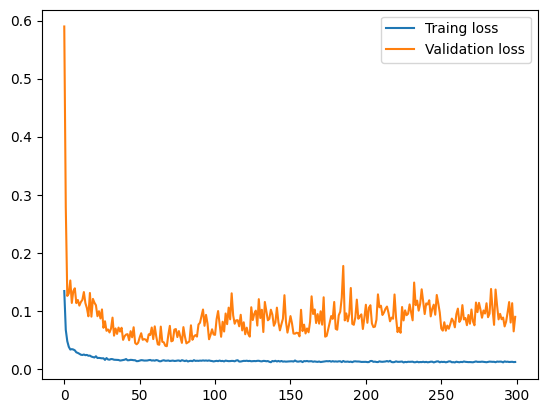

In [ ]:
plt.plot(validation.history['loss'], label='Traing loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
# Fazer previsões usando o modelo
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

14/14 [==============================] - 0s 9ms/step


array([[37.442432 ],
       [37.84142  ],
       [38.30128  ],
       [38.32371  ],
       [38.51947  ],
       [38.8862   ],
       [38.962162 ],
       [39.08683  ],
       [38.70405  ],
       [38.22714  ],
       [38.55816  ],
       [38.682926 ],
       [39.24113  ],
       [39.118027 ],
       [39.143097 ],
       [38.901524 ],
       [38.66706  ],
       [38.3104   ],
       [38.273285 ],
       [38.560787 ],
       [38.74926  ],
       [38.731197 ],
       [38.689342 ],
       [38.914352 ],
       [38.51784  ],
       [38.22024  ],
       [38.012096 ],
       [38.252403 ],
       [38.47222  ],
       [37.996853 ],
       [37.795845 ],
       [37.39339  ],
       [37.210167 ],
       [36.967533 ],
       [37.12407  ],
       [37.223778 ],
       [37.175358 ],
       [37.237877 ],
       [37.89726  ],
       [37.800915 ],
       [37.598137 ],
       [37.359417 ],
       [37.327423 ],
       [37.62362  ],
       [37.66051  ],
       [37.750656 ],
       [37.56123  ],
       [37.29

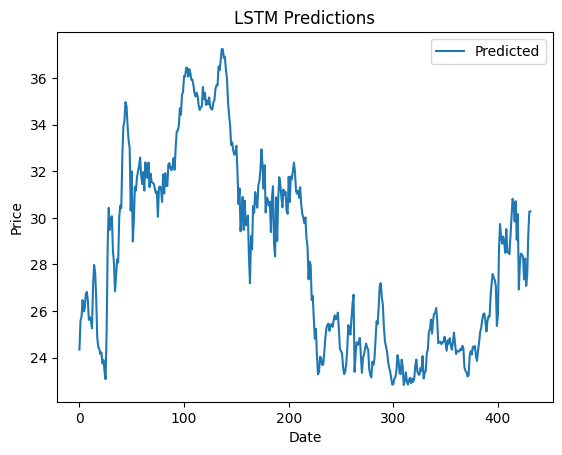

In [ ]:
# Plot os valores previstos
plt.plot(prev, label='Predicted')
plt.title('LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

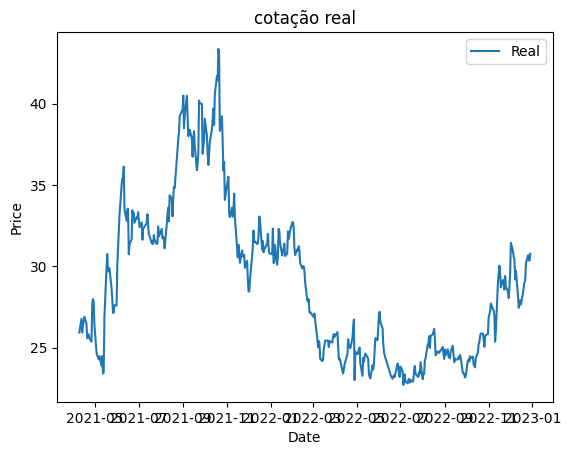

In [ ]:
dados_csna_final = dados_csna['Close'][-432:]

# Plot dos valores reais
plt.plot(dados_csna_final, label= 'Real')
plt.title('cotação real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

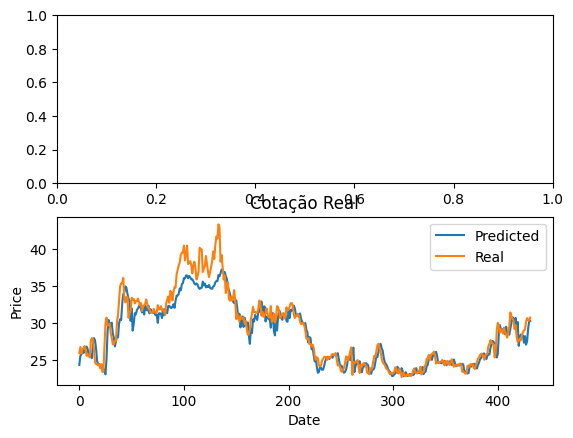

In [ ]:
fig, axes = plt.subplots(2, 1)

# Plot dos valores previstos
plt.plot(prev, label='Predicted')
plt.legend()

# Plot dos valores reais
plt.plot(dados_csna_final, label='Real')
plt.title('Cotação Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()